In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

from matplotlib import pyplot as plt

import os,sys
se2cnn_source =  os.path.join(os.getcwd(),'..')
if se2cnn_source not in sys.path:
    sys.path.append(se2cnn_source)

from se2cnn.layers import LiftingLayer, SE2Layer, ConcatOrientation

In [2]:
 gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

## Load mnist data

In [3]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Setup model

In [4]:
n_theta = 4

In [5]:
model = tf.keras.Sequential(
    [
        layers.Input(shape=input_shape),
        LiftingLayer(16,5, n_theta=n_theta, strides=(1,1,1,1), activation="relu", name='lifting', use_bias=False),
        SE2Layer(32,5, n_theta=n_theta, strides=(1,2,2,1), activation="relu", name='se2', use_bias=False),
        ConcatOrientation(),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", groups=2),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lifting (LiftingLayer)       (None, 24, 24, 4, 16)     400       
_________________________________________________________________
se2 (SE2Layer)               (None, 10, 10, 4, 32)     51200     
_________________________________________________________________
concat_orientation (ConcatOr (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

## Train

In [6]:
epochs = 5
batch_size = 128

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
422/422 [==============================] - 6s 10ms/step - loss: 0.6240 - accuracy: 0.7902 - val_loss: 0.0568 - val_accuracy: 0.9838
Epoch 2/5
422/422 [==============================] - 4s 9ms/step - loss: 0.0939 - accuracy: 0.9721 - val_loss: 0.0394 - val_accuracy: 0.9897
Epoch 3/5
422/422 [==============================] - 3s 8ms/step - loss: 0.0626 - accuracy: 0.9800 - val_loss: 0.0317 - val_accuracy: 0.9913
Epoch 4/5
422/422 [==============================] - 3s 8ms/step - loss: 0.0474 - accuracy: 0.9855 - val_loss: 0.0326 - val_accuracy: 0.9908
Epoch 5/5
422/422 [==============================] - 3s 8ms/step - loss: 0.0413 - accuracy: 0.9862 - val_loss: 0.0293 - val_accuracy: 0.9920


## Evaluate

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.022170662879943848
Test accuracy: 0.9922999739646912


## Inspect kernels


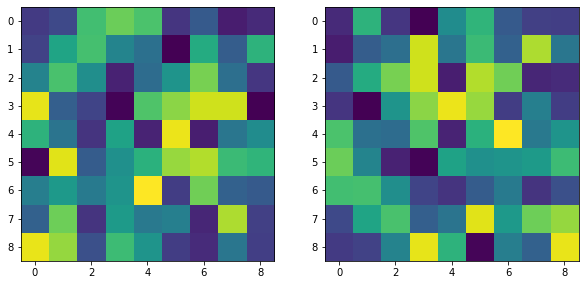

In [8]:
random_input = np.random.rand(1,9,9,1) #+ x_train[0:1]

# And a 90 degree counter clock-wise rotated version
random_input_90 = np.transpose(np.flip(random_input,2),[0,2,1,3])

#Plot
f,axs = plt.subplots(1,2,figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(random_input[0,:,:,0])
plt.subplot(1,2,2)
plt.imshow(random_input_90[0,:,:,0])
plt.show()



In [9]:
lifting_layer = model.get_layer('lifting')
se2_layer = model.get_layer('se2')

lifting_layer = LiftingLayer(1,5, n_theta=n_theta, strides=(1,1,1,1), activation=None, name='lifting', use_bias=False, disk_mask=False)
se2_layer = SE2Layer(1,5, n_theta=n_theta, strides=(1,2,2,1), activation=None, name='se2', use_bias=False, disk_mask=False)

In [10]:
t_lifted = lifting_layer(random_input)
t_lifted_90 = lifting_layer(random_input_90)

t_lifted_2 = se2_layer(lifting_layer(random_input))
t_lifted_2_90 = se2_layer(lifting_layer(random_input_90))

In [11]:
_, lifting_k = lifting_layer.rotate_kernel()
_, gconv_k = se2_layer.rotate_kernel()

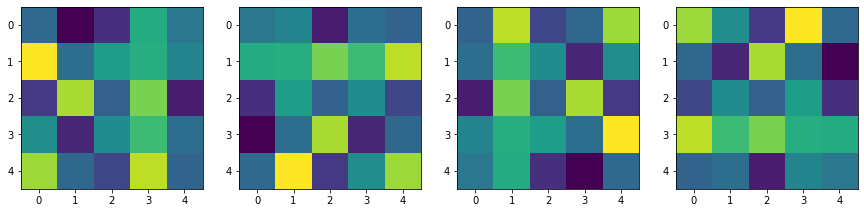

Rotated versions of the lifting kernels


In [12]:
plt.subplots(1,n_theta,figsize=(15,15))
for i in range(n_theta):
    plt.subplot(1,n_theta,i+1)
    plt.imshow(lifting_k[i,:,:,0,0])
plt.show()

print( 'Rotated versions of the lifting kernels')

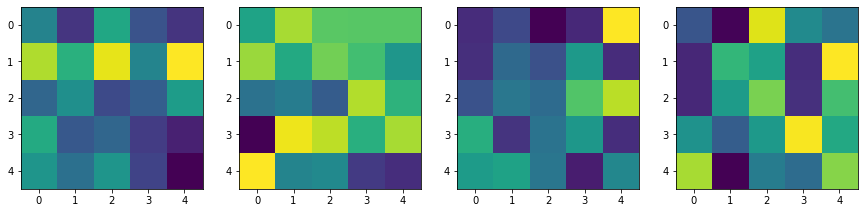

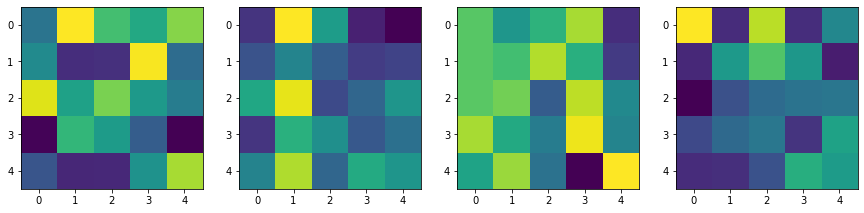

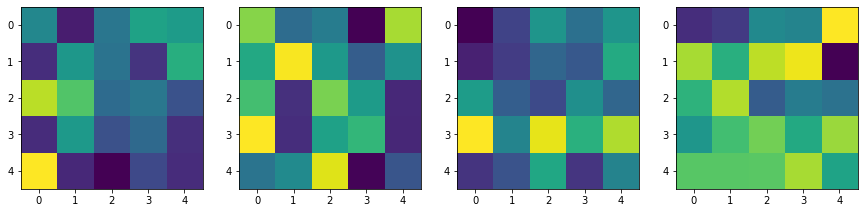

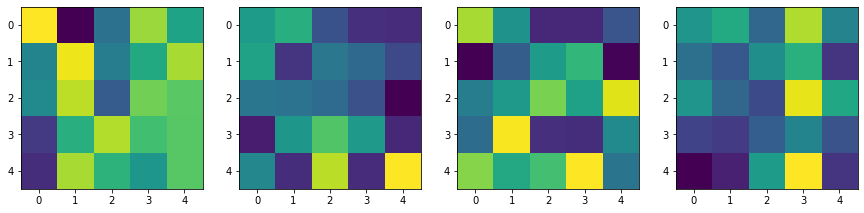

Each row is a rotated version of an se2 kernel (planar rotation + shift in theta direction)


In [13]:
for rot in range(n_theta):
    plt.show()
    plt.subplots(1,n_theta,figsize=(15,15))
    for i in range(n_theta):
        plt.subplot(1,n_theta,i+1)
        plt.imshow(gconv_k[rot,:,:,i,0,0])
    plt.show()
print( 'Each row is a rotated version of an se2 kernel (planar rotation + shift in theta direction)')

### Check covariance of the lifting layer

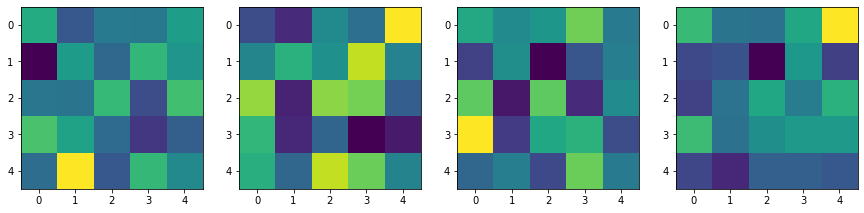

The unrotated input.


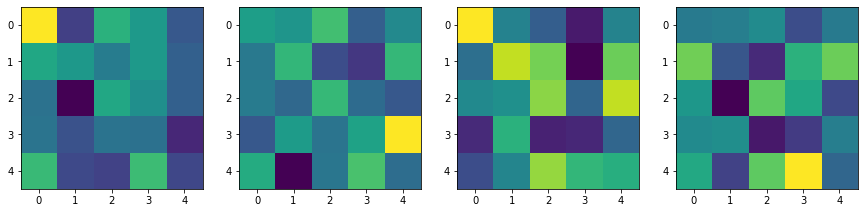

The 90-degree rotated input. Notice a shift of n_theta/4 (=90/360*Ntheta) bins and a rotation of 90 of each plane.


In [14]:
#Plot
plt.subplots(1,n_theta,figsize=(15,15))
for i in range(n_theta):
    plt.subplot(1,n_theta,i+1)
    plt.imshow(t_lifted[0,:,:,i,0])
plt.show()
print( 'The unrotated input.')
plt.subplots(1,n_theta,figsize=(15,15))
for i in range(n_theta):
    plt.subplot(1,n_theta,i+1)
    plt.imshow(t_lifted_90[0,:,:,i,0])
plt.show()

print( 'The 90-degree rotated input. Notice a shift of n_theta/4 (=90/360*Ntheta) bins and a rotation of 90 of each plane.')

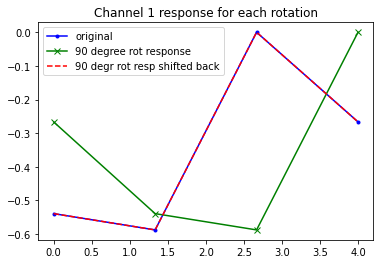

In [15]:
# Simple data to display in various forms
#x = np.linspace(0, 2 * np.pi, n_theta)
x = np.linspace(0, n_theta, n_theta)
y = t_lifted_2[0,0,0,:,0]
y_90 = t_lifted_2_90[0,0,0,:,0]
y_90_back = np.roll(t_lifted_2_90[0,0,0,:,0],-int(n_theta/4))
plt.figure()
plt.plot(x, y,'b.-' , label='original')
plt.plot(x, y_90, 'gx-', label='90 degree rot response')
plt.plot(x, y_90_back,'r--', label='90 degr rot resp shifted back')
plt.title('Channel 1 response for each rotation')
plt.legend()
plt.show()